# Weather Classification for Disaster Risk Reduction with DenseNet-161

*Project by:* Elizabeth Olorunleke   

 I'm working with a weather image dataset to build an image classification model with Pytorch. The goal is to use this project in responding to natural disasters. 

## The MWD Dataset

The Multi-class Weather Dataset(MWD) for Image Classification is a valuable dataset used in the research paper entitled “Multi-class weather recognition from the still image using heterogeneous ensemble method” published by Ajayi, Gbeminiyi from University of South Africa - Science Campus. It contains 4 classes of  images: Sunrise, Shine, Rain, Cloudy. Each class has 200-350 pictures.

## Steps in this notebook
In this notebook, i am taking these 7 steps:
1. install packages
2. prepare dataset
3. dataset normalization
4. load the DenseNet-161
5. train(fine-tune) a model 
6. test a model 
7. show predictions graphs and confusion matrix





## 1. Install packages

Here i'll install python packages for later use

- **torch**: [PyTorch](https://pytorch.org/) is a Python package that provides two high-level features: (1) Tensor computation (like NumPy) with strong GPU acceleration (2) Deep neural networks built on a tape-based autograd system

- **torchvision**: The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.

- **matplotlib**: Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.

In [1]:
%pip install torch 
%pip install torchvision
%pip install matplotlib
%pip install sklearn

     |████████████████████████████████| 779.1 MB 13 kB/s  eta 0:00:0112       | 114.3 MB 117.4 MB/s eta 0:00:0606     |██████████                      | 245.2 MB 9.0 MB/s eta 0:01:00██████████▋                     | 258.8 MB 9.0 MB/s eta 0:00:58████████                    | 290.3 MB 50.8 MB/s eta 0:00:10�█████████▎                 | 347.6 MB 50.8 MB/s eta 0:00:09�██████████                 | 367.3 MB 89.5 MB/s eta 0:00:05/s eta 0:00:05/s eta 0:00:05/s eta 0:00:05��▌               | 401.6 MB 89.5 MB/s eta 0:00:05��█████████████▎              | 420.5 MB 52.9 MB/s eta 0:00:07��█████████████▍              | 422.7 MB 52.9 MB/s eta 0:00:07███████▋              | 428.3 MB 52.9 MB/s eta 0:00:07��█████████████▊              | 432.1 MB 52.9 MB/s eta 0:00:07████████              | 439.6 MB 52.9 MB/s eta 0:00:07MB/s eta 0:00:07��█▋            | 477.8 MB 52.9 MB/s eta 0:00:06�███            | 487.6 MB 78.2 MB/s eta 0:00:04��█████           | 510.6 MB 78.2 MB/s eta 0:00:04     |█████████████████████

In [1]:
import torch
import torchvision

In [2]:
# Use is_available() to determine if your system supports CUDA.
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu" 
device

'cpu'

## 2. Prepare dataset

Next, you will need to download a Kaggle dataset manually from their [dataset download page](https://www.kaggle.com/pratik2901/multiclass-weather-dataset). Once you've done that, create a new folder here called "dataset", and upload those files into that directory. 

Please make sure your files looks like this once you are done.
```
  -- root
    -- notebook
    -- dataset
      -- cloudy
      -- rainy
      -- shine
      -- sunrise
```

In [5]:
!unzip "archive.zip"

Archive:  archive.zip
  inflating: Multi-class Weather Dataset/Cloudy/cloudy1.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy10.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy100.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy101.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy102.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy103.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy104.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy105.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy106.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy107.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy108.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy109.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy11.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy110.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy111.jpg  
  inflating: Multi-cla

In [6]:
!mv "Multi-class Weather Dataset" dataset

### 2.1 Reading Image Data

In [7]:
def GetImagesFromFolder(PATH, Class_Folder, ext):
    """
    This module can be used to import image data. 
    It also takes care of resizing the images to 240x240 Pixels.
    So that the images can be used for DenseNet-161 model fine-tuning.
    """
    images = [Image.open(file).convert('RGB').resize((240,240),resample=Image.LANCZOS) for e in ext for file in glob.glob(PATH+Class_Folder+'/*.' + e)] 
    print(f"Found {len(images)} in folder {Class_Folder}")
    np.random.shuffle(images)
    return images,np.array([Class_Folder for i in range(len(images))])

In [8]:
"""
Read the image from given path.
1. use LabelEncoder from sklearn to encode the folder names and the class number.
2. for each folder, add image and labels to ALL_IMAGES and ALL_LABEL.
"""
import os
import datetime
import glob
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder

DATA_PATH = './dataset/'
FOLDERS = os.listdir(DATA_PATH)
print(FOLDERS)

### if you found the folder contains other subfolder than the iamge classes, 
### remove them before calling the label encoder
#if os.path.exists("./dataset/.ipynb_checkpoints/"):
#    os.rmdir("./dataset/.ipynb_checkpoints/")

ALL_IMAGES,ALL_LABELS = [],[]
images_population ={}
ext = ['jpg','jpeg']

for Class_Folder in FOLDERS:
    IMAGES,LABELS = GetImagesFromFolder(DATA_PATH,Class_Folder,ext)
    images_population[Class_Folder] = LABELS.shape[0]
    ALL_IMAGES.extend(IMAGES)
    ALL_LABELS.extend(LABELS)
        
le = LabelEncoder().fit(FOLDERS)
print(le)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

['Cloudy', 'Rain', 'Shine', 'Sunrise']
Found 300 in folder Cloudy
Found 215 in folder Rain
Found 253 in folder Shine
Found 357 in folder Sunrise
LabelEncoder()
{'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}


### 2.2 Splitting Dataset to different splits for Training, Testing & Validation:

In [9]:
from sklearn.model_selection import train_test_split
TRAIN_IMAGES, X_val_test, TRAIN_LABELS, y_val_test = train_test_split(ALL_IMAGES, ALL_LABELS, test_size=0.20, random_state=42,stratify=ALL_LABELS)
VAL_IMAGES, TEST_IMAGES, VAL_LABELS, TEST_LABELS =  train_test_split(X_val_test, y_val_test, test_size=0.50, random_state=42,stratify=y_val_test)

### 2.3 Create WeatherDataset class:

In [10]:
from torch.utils.data import DataLoader,Dataset

class WeatherDataset(Dataset):
    def __init__(self, ImageData, Target, transform=None):
        self.ImageData = ImageData
        self.Target = torch.LongTensor(le.transform(Target))
        self.transform = transform

    def __getitem__(self, index):
        x = self.ImageData[index]
        y = self.Target[index]
        if self.transform:
            x = Image.fromarray(np.uint8(np.array(self.ImageData[index]))) # Memory Efficient way
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.ImageData)


## 3. Dataset Normalization
This is a utility function to find out MEAN & STD for Normalizing Training Data

In [11]:
# SOURCE: https://youtu.be/y6IEcEBRZks
from torchvision import transforms
def get_mean_std(loader):
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0,0,0
    
    for data,_ in loader:
        channels_sum +=torch.mean(data,dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    return mean,std

batch_size = 4
transform = transforms.Compose([transforms.Resize((230,230)),transforms.ToTensor()])
dataset = WeatherDataset(TRAIN_IMAGES, TRAIN_LABELS, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4)
mean,std = get_mean_std(loader)
print(f"Data loader has:\n*\tmean= {mean.tolist()}\n*\tstd= {std.tolist()}")

Data loader has:
*	mean= [0.46382924914360046, 0.4566137492656708, 0.4494249224662781]
*	std= [0.26681387424468994, 0.2481355518102646, 0.29166942834854126]


In [12]:
transform = {'train':transforms.Compose([transforms.ColorJitter(),
                                         transforms.RandomRotation(30),
                                         transforms.Resize((240,240)),
                                         transforms.RandomResizedCrop(230),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=mean,std=std),#transforms.RandomErasing()
                                        ]),
             'val':transforms.Compose([transforms.Resize((230,230)),
                                      transforms.ToTensor()]),
             
             'test':transforms.Compose([transforms.Resize((230,230)),
                                      transforms.ToTensor()])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


batch_size = {'train':8, 'val':8,'test':8}

dataset_classes = ['Cloudy','Rain','Shine','Sunrise']


image_datasets = {'train': WeatherDataset(TRAIN_IMAGES, TRAIN_LABELS, transform=transform['train']),
                  'val':   WeatherDataset(VAL_IMAGES, VAL_LABELS, transform=transform['val']),
                  'test':  WeatherDataset(TEST_IMAGES, TEST_LABELS, transform=transform['test'])
}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

dataloaders = {indx: torch.utils.data.DataLoader(image_datasets[indx], batch_size=batch_size[indx], num_workers=4, pin_memory=True, shuffle=True)
              for indx in batch_size.keys()}

print("Size for Dataset:\n\t* Train: %d\n\t* Valid: %d\n\t* Test: %d"%(dataset_sizes['train'],dataset_sizes['val'],dataset_sizes['test']))


Size for Dataset:
	* Train: 900
	* Valid: 112
	* Test: 113


## 4. Load the DenseNet-161

In [13]:
import gc
def train_model(model, criterion, optimizer, model_checkpoint=0, early_stop = 10, num_epochs=5):
    start_time = datetime.datetime.now().replace(microsecond=0)
    model = model.to(device)

    # number of epochs to train the model
    valid_loss_min = np.Inf # track change in validation loss
    early_stop_cnt = 0
    last_epoch_loss = np.Inf
    globaliter = 0

    final_loss = np.Inf

    for epoch in range(1, num_epochs+1):
        globaliter+=1
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0


        ###################
        # train the model #
        ###################
        model.train()
        train_corrects = 0

        for data, target in dataloaders['train']:
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, preds = torch.max(output, 1)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            train_corrects += torch.sum(preds == target.data)

        train_loss = train_loss/len(dataloaders['train'].dataset)
        train_acc = (train_corrects.double()*100)/len(dataloaders['train'].dataset)

        ######################    
        # validate the model #
        ######################
        model.eval()
        val_corrects = 0
        for data, target in dataloaders['val']:
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            _, preds = torch.max(output, 1)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.item()*data.size(0)
            val_corrects += torch.sum(preds == target.data)

        # calculate average losses
        valid_loss = valid_loss/len(dataloaders['val'].dataset)
        valid_acc = (val_corrects.double()*100)/len(dataloaders['val'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss:  {:.6f} \tValidation Loss:  {:.6f}'.format(epoch, train_loss, valid_loss))
        print('\t\tTraining Acc:  {:.3f} \t\tValidation Acc:  {:.3f}'.format(train_acc, valid_acc))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).'.format(valid_loss_min,valid_loss))
            if model_checkpoint != 0:
                torch.save(model.state_dict(), '/kaggle/working/model.pt'.format(train_acc, valid_acc))
                print('Model Saved: /kaggle/working/model.pt'.format(train_acc, valid_acc))
            valid_loss_min = valid_loss
        elif valid_loss == np.nan:
            print("Model Loss: NAN")

        if (last_epoch_loss < valid_loss) and last_epoch_loss != np.Inf:
            early_stop_cnt +=1
            if early_stop_cnt == early_stop:
                print('-'*50+"\nEarly Stopping Hit\n"+'-'*50)
                break
            else:
                print('-'*50+f"\n\t\tEarly Stopping Step: {early_stop_cnt}/{early_stop}\n"+'-'*50)
        else:
            early_stop_cnt = 0
            last_epoch_loss = valid_loss

    print(f"Training Completed with best model having loss of {round(valid_loss_min,6)}")
    del data,target
    gc.collect()
    end_time = datetime.datetime.now().replace(microsecond=0)
    print(f'Time Taken: {end_time-start_time}')
    return model

In [14]:
from torchvision import models
import torch.nn as nn
#import torch.nn.functional as F
n_classes = 4
epochs = 1

n_classes = len(dataset_classes)
print(n_classes)

model_ft = models.densenet161(pretrained=True)
# Using Model as Feature Extractor
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, n_classes)
model_ft = model_ft.to(device)


4


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/studio-lab-user/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100.0%


## 5. Fine-tune the pre-trained model on the labelled weather data

Setup the hyperparameters, for example learning rate, momentum, decay and optimization function.

In [15]:
import torch.optim as optim
# Cross Entropy Loss 
criterion = nn.CrossEntropyLoss()

# SGD Optimizer
lr = 0.01
momentum = 0.5
decay = 0.01
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum = momentum, weight_decay = decay)

In [16]:
print('Training of Model:')
model_ft = train_model(model_ft, criterion, optimizer_ft,model_checkpoint=0,num_epochs=epochs)

Training of Model:
Epoch: 1 	Training Loss:  0.774298 	Validation Loss:  0.338477
		Training Acc:  68.778 		Validation Acc:  89.286
		Validation loss decreased (inf --> 0.338477).
Training Completed with best model having loss of 0.338477
Time Taken: 0:06:42


## 6. test a model
Visualize the predict label and the truth label

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (num_images,num_images))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {dataset_classes[preds[j]]} | Actual: {dataset_classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    if device.type == 'cuda':
        inputs = inputs.cpu()
        labels = labels.cpu()
    gc.collect()

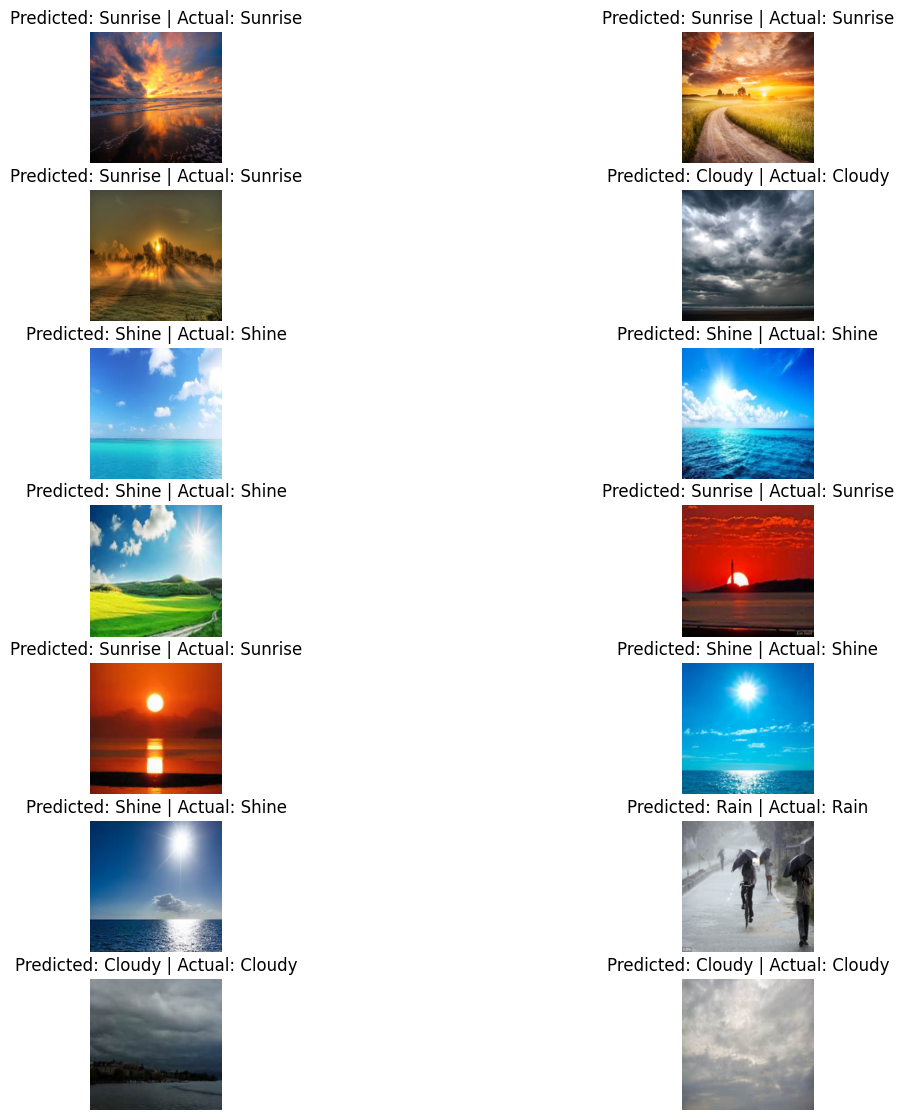

In [18]:
def imshow(img):
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))
    
visualize_model(model_ft, num_images=14)

## 7. Show predictions graphs and confusion matrix
- [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix): In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one.

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    size = len(classes)*2
    plt.figure(figsize = (size,size))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)

def model_verification(loader,batch_size,model,n_classes=5):
    classes = list(le.inverse_transform([i for i in range(n_classes)]))
    prediction_list,label_list = [],[]
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = outputs.argmax(dim=1).detach()
            prediction_list.extend(predicted.tolist())
            label_list.extend(labels.tolist())
            
    cm = confusion_matrix(prediction_list,label_list)
    plot_confusion_matrix(cm, classes)
    if device.type == 'cuda':
        inputs = inputs.cpu()
        labels = labels.cpu()
    gc.collect()

Confusion matrix, without normalization
[[28  1  0  0]
 [ 0 21  1  1]
 [ 1  0 22  5]
 [ 1  0  2 29]]


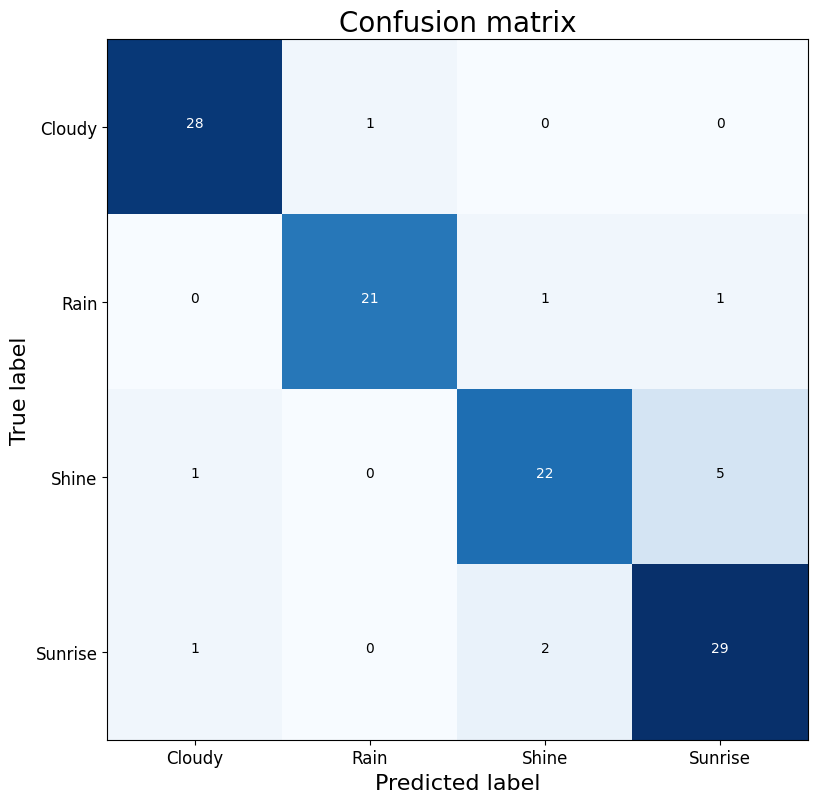

In [21]:
model_verification(dataloaders['val'],batch_size['val'],model_ft,n_classes=4)